In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import regularizers
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import pandas as pd
import time

### Paths

In [3]:
celeba_path = Path('../../../Dataset/img_celeba_cropped/')
celeba_identity_path = Path('../../../Dataset/identity_CelebA.txt')
celeba_attributes_path = Path('../../../Dataset/list_attr_celeba.txt')

### Hyperparameters

In [4]:
triplets_count=50

train_size=0.7

network_input_shape=(224, 224, 3)

batch_size=32
lr=1e-5

### Creating triplets

In [5]:
df_identity = pd.read_csv(celeba_identity_path, sep = " ", names=["image", "identity"], dtype=str)

In [6]:
def create_n_triplets(df_identity, n):
    triplets = []
    
    for triplet in range(n):
        anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)
    
        anchor, positive = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True)
        negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)
        
        anchor = str(celeba_path) + '/' + anchor
        positive = str(celeba_path) + '/' + positive
        negative = str(celeba_path) + '/' + negative
        
        triplets.append([anchor, positive, negative])
        
    
    return pd.DataFrame(triplets, columns=['anchor', 'positive', 'negative'])

In [7]:
triplets = create_n_triplets(df_identity, triplets_count)

triplets.head()

,anchor,positive,negative
0,../../../Dataset/img_celeba_cropped/121936.jpg,../../../Dataset/img_celeba_cropped/102984.jpg,../../../Dataset/img_celeba_cropped/149532.jpg
1,../../../Dataset/img_celeba_cropped/107526.jpg,../../../Dataset/img_celeba_cropped/125785.jpg,../../../Dataset/img_celeba_cropped/081374.jpg
2,../../../Dataset/img_celeba_cropped/079020.jpg,../../../Dataset/img_celeba_cropped/160774.jpg,../../../Dataset/img_celeba_cropped/103792.jpg
3,../../../Dataset/img_celeba_cropped/147361.jpg,../../../Dataset/img_celeba_cropped/097329.jpg,../../../Dataset/img_celeba_cropped/095073.jpg
4,../../../Dataset/img_celeba_cropped/058993.jpg,../../../Dataset/img_celeba_cropped/153606.jpg,../../../Dataset/img_celeba_cropped/087675.jpg


In [8]:
def visualize_triplets(triplets):
    def show(ax, path):
        img = cv2.imread(path)
        
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], triplets.iloc[i][0])
        show(axs[i, 1], triplets.iloc[i][1])
        show(axs[i, 2], triplets.iloc[i][2])

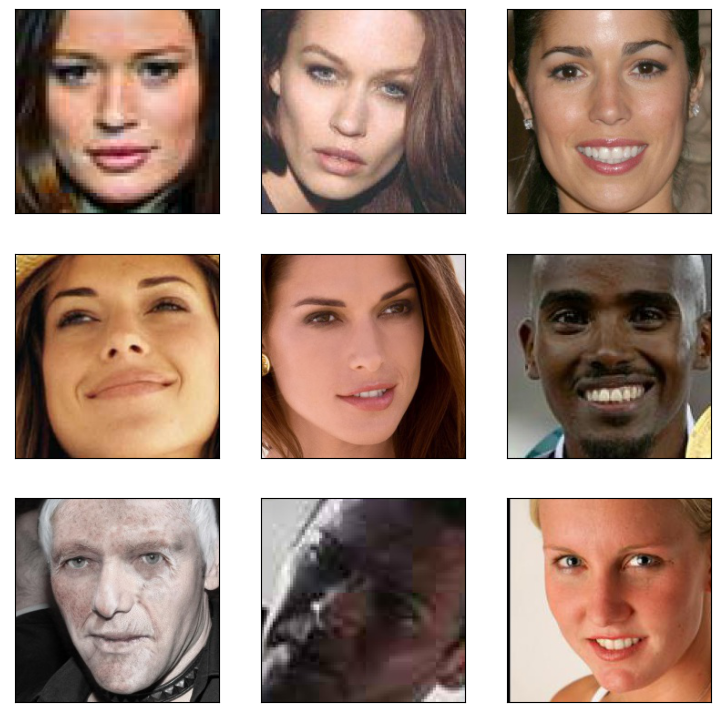

In [9]:
visualize_triplets(triplets)

### Pipeline

In [10]:
def preprocessing(anchor, positive, negative):
    return (
        convert_to_img(anchor), 
        convert_to_img(positive), 
        convert_to_img(negative)
    )


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

In [11]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(triplets['anchor'].values)
positive_dataset = tf.data.Dataset.from_tensor_slices(triplets['positive'].values)
negative_dataset = tf.data.Dataset.from_tensor_slices(triplets['negative'].values)

fake_labels = tf.data.Dataset.from_tensor_slices(np.ones(triplets_count))

features = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
features = features.map(preprocessing)

dataset = tf.data.Dataset.zip((features, fake_labels))

Metal device set to: Apple M1 Pro


2022-12-03 01:08:23.224570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-03 01:08:23.224876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Test val splits

In [12]:
train_dataset = dataset.take(round(triplets_count * train_size))
val_dataset = dataset.skip(round(triplets_count * train_size))

train_dataset = train_dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Models

### Resnet 50

In [13]:
def resnet_embedding():
    input = layers.Input(shape=network_input_shape)
    
    base_cnn=resnet50.ResNet50(
        input_tensor=input,
        include_top=False,
        input_shape=network_input_shape,
        weights='imagenet'
    )

    for layer in base_cnn.layers[0:-1]:
        layer.trainable = False
        
    model = layers.Flatten()(base_cnn.output)
    #model = layers.Dense(4096, activation="relu")(model)
    #model = tf.keras.layers.Dropout(0.1)(model)
    model = layers.BatchNormalization()(model)
    #model = layers.Dense(4096, activation="relu")(model)
    #model = tf.keras.layers.Dropout(0.1)(model)
    #model = layers.BatchNormalization()(model)
    model = layers.Dense(4096, activation="relu")(model)

    return Model(input, outputs=model, name='resnet50')

### Convnet

In [14]:
def conv_embedding():
    input = layers.Input(shape=network_input_shape)
    x = layers.Flatten()(input)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    
    x = layers.Dense(248, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    
    x = layers.Dense(248, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    return Model(inputs=input, outputs=x, name='dense_net')

In [15]:
anchor_input = layers.Input(shape=network_input_shape, name='anchor_input')
positive_input = layers.Input(shape=network_input_shape, name='right_input')
negative_input = layers.Input(shape=network_input_shape, name='negative_input')

#embedding = convnet_embedding()
embedding = resnet_embedding()

In [16]:
class TripletLoss(layers.Layer):

    def __init__(self, margin, **kwargs):
        self.margin = margin
        super().__init__(**kwargs)
        
    def distance(self, x, y):
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, K.epsilon()))
    

    def call(self, anchor, positive, negative):
        positive_distance = self.distance(anchor, positive)
        negative_distance = self.distance(anchor, negative)
        
        loss = positive_distance - negative_distance
        
        return tf.maximum(loss + self.margin, 0.0)

In [17]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

In [18]:
distances = TripletLoss(margin=1)(
    embedding(resnet50.preprocess_input(anchor_input)),
    embedding(resnet50.preprocess_input(positive_input)),
    embedding(resnet50.preprocess_input(negative_input)),
)

model = Model(
    inputs=[anchor_input, positive_input, negative_input], 
    outputs=distances,
    name='resnet50',
)

In [19]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

In [20]:
model.compile(
    optimizer=Adam(learning_rate=lr), 
    loss = identity_loss,
    metrics=['Accuracy']
)

### a) Loading model

In [21]:
#model_path = 'foo'
#model = keras.models.load_model(model_path)

### Callbacks

In [22]:
tensorboard = TensorBoard(
    log_dir=f"logs/{model.name}_{time.strftime('run_%Y_%m_%d-%H_%M_%S')}",
    histogram_freq = 1, 
    embeddings_freq=1)

In [23]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
    #min_delta=
)

In [24]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

lr_scheduler_decay = keras.callbacks.LearningRateScheduler(exponential_decay(lr0 = 0.1, s = 10))

In [25]:
lr_scheduler_reduce = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [26]:
callbacks_list = [
    tensorboard,
    early_stopping,
    lr_scheduler_reduce,
]

### b) Training and saving a new model

In [ ]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    callbacks=callbacks_list,
    epochs=30, 
)

Layer TripletLoss has arguments ['margin']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/30


2022-12-03 01:08:25.635547: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-03 01:08:27.818971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 1.5242 - Accuracy: 0.4857

2022-12-03 01:08:33.860375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Save model

In [ ]:
#!cd {checkpoint_path} && mkdir {model_version}

#checkpoints_path = 'checkpoints'
#model_version = f'{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

#model_path = f'checkpoints/{model_version}'
#model.model.save(model_path)

### Performance evaluation

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

In [ ]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

### Predictions

In [ ]:
def create_balanced_pairs(df_identity, images):
    pairs = []
    
    for triplet in range(images):
        anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)
        
        positive_pair = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True).to_list()
        negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)
        
        positive_pair[0] = str(celeba_path) + '/' + positive_pair[0]
        positive_pair[1] = str(celeba_path) + '/' + positive_pair[1]
        negative = str(celeba_path) + '/' + negative
        
        pairs.append([positive_pair[0], positive_pair[1], 1])
        pairs.append([positive_pair[0], negative, 0])
    
    return pd.DataFrame(pairs, columns=['left', 'right', 'label'])

In [ ]:
pairs = create_balanced_pairs(df_identity, 50)

In [ ]:
pairs.head(6)

In [ ]:
def visualize_pairs(pairs):
    def show(ax, path):
        img = cv2.imread(path)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(5, 15))

    axs = fig.subplots(6, 2)
    for i in range(6):
        show(axs[i, 0], pairs.iloc[i][0])
        show(axs[i, 1], pairs.iloc[i][1])

In [ ]:
visualize_pairs(pairs)

In [ ]:
def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [ ]:
test_ds_left = create_singular_dataset(pairs['left'])
test_ds_right = create_singular_dataset(pairs['right'])
test_labels = pairs['label']

In [ ]:
left_image_feature_vectors = embedding.predict(test_ds_left)
right_image_feature_vectors = embedding.predict(test_ds_right)

In [ ]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [ ]:
positive_distances = np.linalg.norm(positive_left_image_feature_vectors - positive_right_image_feature_vectors, axis=1)
positive_mean = pd.Series(positive_distances).mean()
pd.Series(positive_distances).describe()

In [ ]:
negative_distances = np.linalg.norm(negative_left_image_feature_vectors - negative_right_image_feature_vectors, axis=1)
negative_mean = pd.Series(negative_distances).mean()
pd.Series(negative_distances).describe()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [ ]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred.flatten() < cutoff
    return np.mean(pred == y_true), pred

In [ ]:
y_pred = np.linalg.norm(left_image_feature_vectors-right_image_feature_vectors, axis=1)
cutoff = (positive_mean + negative_mean)/2

In [ ]:
test_accuracy, y_pred = compute_accuracy(test_labels, y_pred, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

In [ ]:
c_matrix = confusion_matrix(y_pred, test_labels, labels = [1,0])
c_matrix_df = pd.DataFrame(c_matrix, index=["TP", "FN"], columns=["FP", "TN"])
plt.figure(figsize=(10,7))
sn.heatmap(c_matrix_df, cmap="Greens", annot=True,
          annot_kws={'fontsize': 20, 'fontweight': 'bold', 'alpha': 0.6})